In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn.tree 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [4]:
def age_group(row):
    rows = row["age"]
    if rows <20:
        return "less than 20"
    elif rows >=20 and rows<30:
        return "20 to 30"
    elif rows >=30 and rows<40:
        return "30 to 40"
    elif rows >=40 and rows<50:
        return "40 to 50"
    elif rows >=50 and rows<60:
        return "50 to 60"
    elif rows >=60 and rows<70:
        return "60 to 70"
    elif rows >=70 and rows<80:
        return "70 to 80"
    elif rows >=80 and rows<90:
        return "80 to 90"
    else:
        return "greater than 90"

In [5]:
from google.colab import drive
drive.mount("/content/drive")
trainData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTrain.csv")
testData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTest.csv")
allData = pd.concat([trainData, testData])

Mounted at /content/drive


In [6]:
allData.drop(columns = {'Unnamed: 0'}, inplace = True)
allData

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [7]:
# age grp
allData["age"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).year-pd.DatetimeIndex(allData["dob"]).year
allData["age_group"] = allData.apply(age_group,axis=1)

# trans times / age
allData["trans_hour"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).hour
allData["trans_yrmth"] = pd.DatetimeIndex(allData['trans_date_trans_time']).strftime('%Y-%m')
allData["weekday"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).weekday
allData["date"] = pd.to_datetime(allData['trans_date_trans_time']).dt.date

# calculating the distance between the merchant location and transaction location
allData["latitude_difference"] = abs(allData["lat"]-allData["merch_lat"])
allData["longitude_difference"] = abs(allData["long"]-allData["merch_long"])

# it is estimated that difference between each degree of longitude and lattitude is approximately 69 miles which is 110 km
# applying pythogoras theorem
allData["distance"] = np.sqrt(pow(allData["latitude_difference"]*110,2)+pow(allData["longitude_difference"]*110,2))
allData['distance'].describe()

allData.category = allData.category.astype("category")
allData.gender = allData.gender.astype("category")
allData.state = allData.state.astype("category")
allData.age_group = allData.age_group.astype("category")
allData.trans_yrmth = allData.trans_yrmth.astype("category")
allData.weekday = allData.weekday.astype("category")
allData.job = allData.job.astype("category")
allData.city = allData.city.astype("category")
allData.is_fraud = allData.is_fraud.astype("category")
allData.trans_hour = allData.trans_hour.astype("category")

#can ignore others, just use train, validation, test
train, others = train_test_split(allData, test_size=0.2, random_state=4012)
del(allData)
validation, test = train_test_split(others, test_size=0.5, random_state=4012)
del(others)

onlyFraud = train[train.is_fraud == 1]
noFraud = train[train.is_fraud != 1]

In [8]:
train.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
train.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

validation.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
validation.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

test.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
test.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

X_train = train[train.columns[~train.columns.isin(["is_fraud"])]]
y_train = train.is_fraud

X_test = test[test.columns[~test.columns.isin(["is_fraud"])]]
y_test = test.is_fraud

X_validation = validation[validation.columns[~test.columns.isin(["is_fraud"])]]
y_validation = validation.is_fraud

In [9]:
#baseline model
numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="mean")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("DecisionTree", DecisionTreeClassifier())
])

time_start = time.perf_counter()

pipeline.fit(X_train, y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(pipeline.predict(X_test))
y_pred

# Track the performance of various models
performance_tracker = pd.DataFrame(columns=["Model Name", "Training Time", "Accuracy", "Recall", "Precision", "F1", "ROC AUC"])
performance_tracker.loc["DecisionTree"] = ["DecisionTree", training_time, accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
performance_tracker

,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
DecisionTree,DecisionTree,193.344408,0.998008,0.779959,0.82876,0.803619,0.889556


In [10]:
model = pipeline[-1]
print(model.get_depth())
print(model.get_n_leaves())
print(model.get_params())

111
2832
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


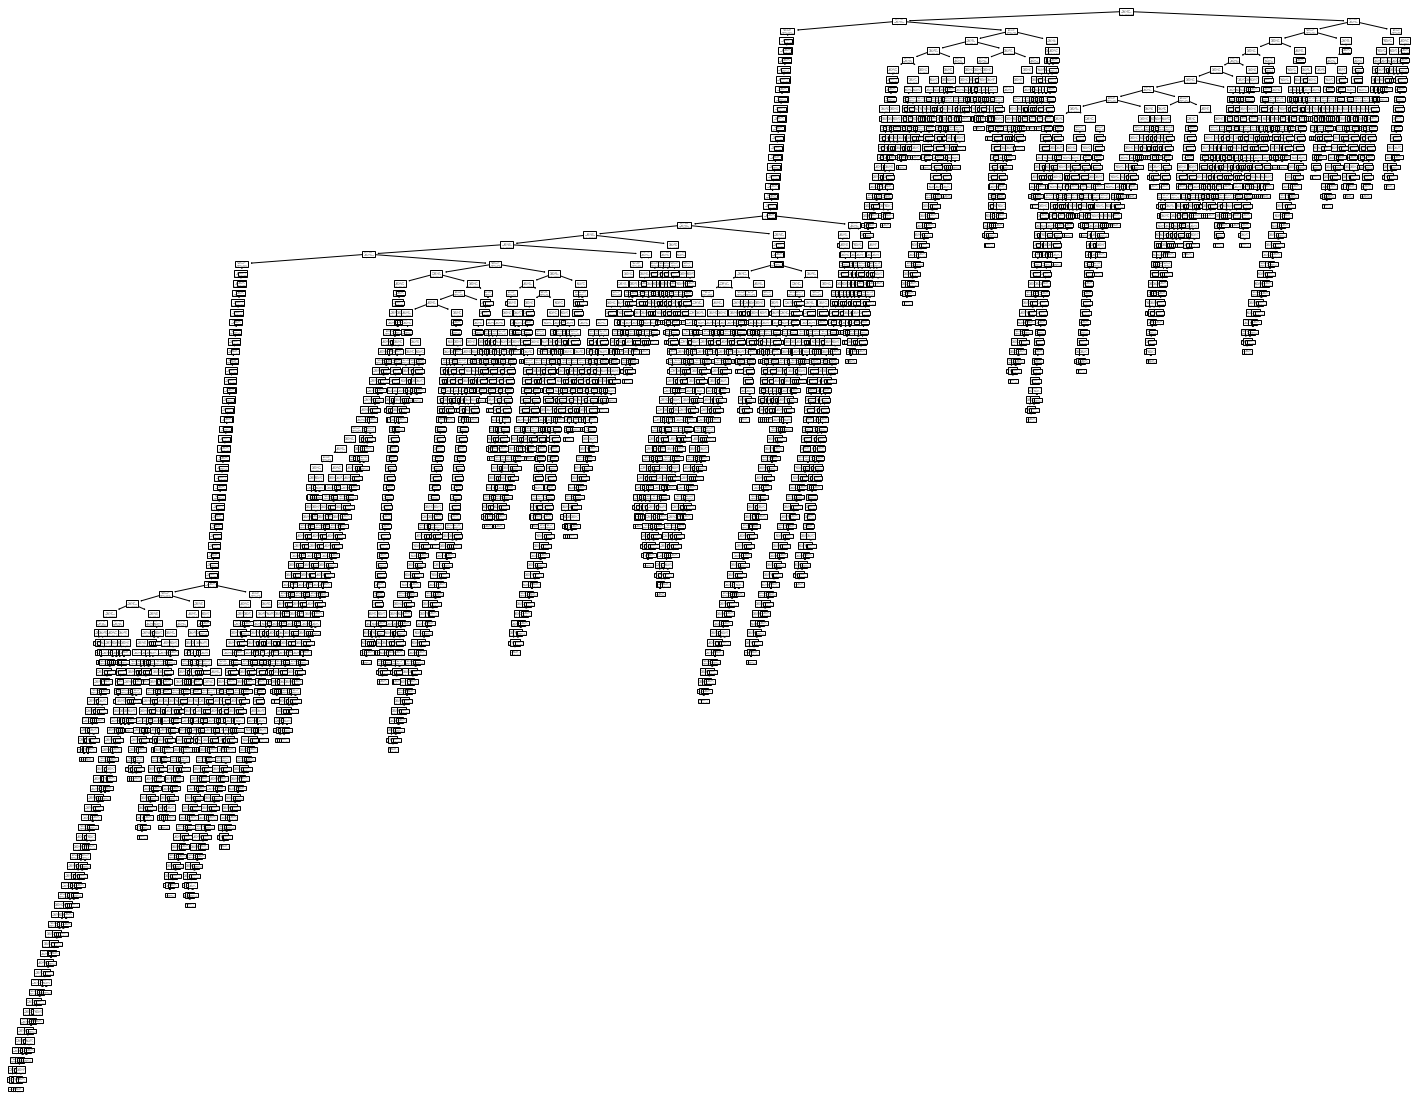

In [11]:
#explanability for baseline model is bad due to huge number of depth and leaves
fig = plt.figure(figsize=(25,20))
_ = sklearn.tree.plot_tree(model)

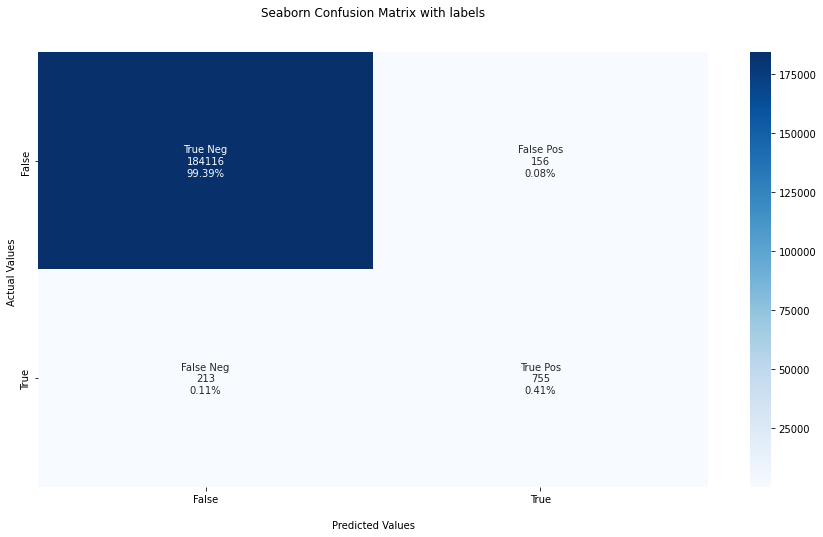

In [12]:
fig, ax = plt.subplots(figsize = (15, 8))
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [13]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.6 MB/s 


In [14]:
#Gridsearch 1
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("DecisionTree", DecisionTreeClassifier())
])

time_start = time.perf_counter()

params2 = {
    'DecisionTree__max_depth': [5, 10, 20],
    'DecisionTree__min_samples_leaf': [10, 20, 50],
    'DecisionTree__criterion': ["gini", "entropy"],
    'DecisionTree__min_samples_split': [10, 30, 60]
}

clf_GS1 = GridSearchCV(pipeline, param_grid = params2, n_jobs = -1)
clf_GS1.fit(X_train, y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(clf_GS1.predict(X_test))
y_pred

print('Best Criterion:', clf_GS1.best_estimator_.get_params()['DecisionTree__criterion'])
print('Best max_depth:', clf_GS1.best_estimator_.get_params()['DecisionTree__max_depth'])
print('Best min_sample_leaf:', clf_GS1.best_estimator_.get_params()['DecisionTree__min_samples_leaf'])
print('Best min_samples_split:', clf_GS1.best_estimator_.get_params()['DecisionTree__min_samples_split'])

# Track the performance of various models
performance_tracker.loc["DecisionTree_GS1"] = ["DecisionTree_GS1", training_time, accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
performance_tracker

Best Criterion: gini
Best max_depth: 20
Best min_sample_leaf: 10
Best min_samples_split: 60


,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
DecisionTree,DecisionTree,193.344408,0.998008,0.779959,0.828760,0.803619,0.889556
DecisionTree_GS1,DecisionTree_GS1,6586.328735,0.998132,0.738636,0.884901,0.805180,0.869066


In [15]:
#first random search
time_start = time.perf_counter()

numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="mean")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("DecisionTree", DecisionTreeClassifier())
])

params3 = {
    'DecisionTree__max_depth': [20, 40, 60],
    'DecisionTree__min_samples_leaf': [8, 10, 12],
    'DecisionTree__min_samples_split': [30, 60, 90, 120]
}

clf_RS1 = RandomizedSearchCV(pipeline, param_distributions = params3, n_jobs = -1)
clf_RS1.fit(X_train, y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(clf_RS1.predict(X_test))
y_pred

print('Best max_depth:', clf_RS1.best_estimator_.get_params()['DecisionTree__max_depth'])
print('Best min_sample_leaf:', clf_RS1.best_estimator_.get_params()['DecisionTree__min_samples_leaf'])
print('Best min_samples_split:', clf_RS1.best_estimator_.get_params()['DecisionTree__min_samples_split'])

# Track the performance of various models
performance_tracker.loc["DecisionTree_RS1"] = ["DecisionTree_RS1", training_time, accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
performance_tracker

Best max_depth: 40
Best min_sample_leaf: 8
Best min_samples_split: 90


,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
DecisionTree,DecisionTree,193.344408,0.998008,0.779959,0.828760,0.803619,0.889556
DecisionTree_GS1,DecisionTree_GS1,6586.328735,0.998132,0.738636,0.884901,0.805180,0.869066
DecisionTree_RS1,DecisionTree_RS1,2838.108739,0.998278,0.752066,0.902107,0.820282,0.875819


In [16]:
#2nd random searched with better params
#performance seems to be better with more depth however this can lead to overfitting
time_start = time.perf_counter()

numeric_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="mean")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric_transformer", numeric_transformer, make_column_selector(dtype_exclude="category")),
    ("categorical_transformer", categorical_transformer, make_column_selector(dtype_include="category"))
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("DecisionTree", DecisionTreeClassifier())
])

params3 = {
    'DecisionTree__max_depth': [40, 60, 80],
    'DecisionTree__min_samples_leaf': [6, 8, 10],
    'DecisionTree__min_samples_split': [90, 120, 150]
}

clf_RS2 = GridSearchCV(pipeline, param_grid = params3, n_jobs = -1)
clf_RS2.fit(X_train, y_train)

training_time = time.perf_counter() - time_start
training_time

y_pred = pd.Series(clf_RS2.predict(X_test))
y_pred

print('Best max_depth:', clf_RS2.best_estimator_.get_params()['DecisionTree__max_depth'])
print('Best min_sample_leaf:', clf_RS2.best_estimator_.get_params()['DecisionTree__min_samples_leaf'])
print('Best min_samples_split:', clf_RS2.best_estimator_.get_params()['DecisionTree__min_samples_split'])

# Track the performance of various models
performance_tracker.loc["DecisionTree_RS2"] = ["DecisionTree_RS2", training_time, accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
performance_tracker

Best max_depth: 80
Best min_sample_leaf: 6
Best min_samples_split: 90


,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
DecisionTree,DecisionTree,193.344408,0.998008,0.779959,0.828760,0.803619,0.889556
DecisionTree_GS1,DecisionTree_GS1,6586.328735,0.998132,0.738636,0.884901,0.805180,0.869066
DecisionTree_RS1,DecisionTree_RS1,2838.108739,0.998278,0.752066,0.902107,0.820282,0.875819
DecisionTree_RS2,DecisionTree_RS2,7587.772780,0.998289,0.752066,0.904348,0.821207,0.875824


In [17]:
#code to get feature importance from a library that can take in a pipeline

import numpy as np  
import pandas as pd  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
import plotly.express as px


class FeatureImportance:

    """
    
    Extract & Plot the Feature Names & Importance Values from a Scikit-Learn Pipeline.
    
    The input is a Pipeline that starts with a ColumnTransformer & ends with a regression or classification model. 
    As intermediate steps, the Pipeline can have any number or no instances from sklearn.feature_selection.

    Note: 
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns, 
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns 
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    
    
    Parameters
    ----------
    pipeline : a Scikit-learn Pipeline class where the a ColumnTransformer is the first element and model estimator is the last element
    verbose : a boolean. Whether to print all of the diagnostics. Default is False.
    
    Attributes
    __________
    column_transformer_features :  A list of the feature names created by the ColumnTransformer prior to any selectors being applied
    transformer_list : A list of the transformer names that correspond with the `column_transformer_features` attribute
    discarded_features : A list of the features names that were not selected by a sklearn.feature_selection instance.
    discarding_selectors : A list of the selector names corresponding with the `discarded_features` attribute
    feature_importance :  A Pandas Series containing the feature importance values and feature names as the index.    
    plot_importances_df : A Pandas DataFrame containing the subset of features and values that are actually displaced in the plot. 
    feature_info_df : A Pandas DataFrame that aggregates the other attributes. The index is column_transformer_features. The transformer column contains the transformer_list.
        value contains the feature_importance values. discarding_selector contains discarding_selectors & is_retained is a Boolean indicating whether the feature was retained.
    
    
    
    """
    def __init__(self, pipeline, verbose=False):
        self.pipeline = pipeline
        self.verbose = verbose


    def get_feature_names(self, verbose=None):  

        """

        Get the column names from the a ColumnTransformer containing transformers & pipelines

        Parameters
        ----------
        verbose : a boolean indicating whether to print summaries. 
            default = False


        Returns
        -------
        a list of the correct feature names

        Note: 
        If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns, 
        it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns 
        to the dataset that didn't exist before, so there should come last in the Pipeline.

        Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525 

        """

        if verbose is None:
            verbose = self.verbose
            
        if verbose: print('''\n\n---------\nRunning get_feature_names\n---------\n''')
        
        column_transformer = self.pipeline[0]        
        assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"
        check_is_fitted(column_transformer)

        new_feature_names, transformer_list = [], []

        for i, transformer_item in enumerate(column_transformer.transformers_): 
            
            transformer_name, transformer, orig_feature_names = transformer_item
            orig_feature_names = list(orig_feature_names)
            
            if verbose: 
                print('\n\n', i, '. Transformer/Pipeline: ', transformer_name, ',', 
                      transformer.__class__.__name__, '\n')
                print('\tn_orig_feature_names:', len(orig_feature_names))

            if transformer == 'drop':
                    
                continue
                
            if isinstance(transformer, Pipeline):
                # if pipeline, get the last transformer in the Pipeline
                transformer = transformer.steps[-1][1]

            if hasattr(transformer, 'get_feature_names'):

                if 'input_features' in transformer.get_feature_names.__code__.co_varnames:

                    names = list(transformer.get_feature_names(orig_feature_names))

                else:

                    names = list(transformer.get_feature_names())

            elif hasattr(transformer,'indicator_') and transformer.add_indicator:
                # is this transformer one of the imputers & did it call the MissingIndicator?

                missing_indicator_indices = transformer.indicator_.features_
                missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                      for idx in missing_indicator_indices]
                names = orig_feature_names + missing_indicators

            elif hasattr(transformer,'features_'):
                # is this a MissingIndicator class? 
                missing_indicator_indices = transformer.features_
                missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                      for idx in missing_indicator_indices]

            else:

                names = orig_feature_names

            if verbose: 
                print('\tn_new_features:', len(names))
                print('\tnew_features:\n', names)

            new_feature_names.extend(names)
            transformer_list.extend([transformer_name] * len(names))
        
        self.transformer_list, self.column_transformer_features = transformer_list,\
                                                                    new_feature_names

        return new_feature_names

    
    def get_selected_features(self, verbose=None):
        """

        Get the Feature Names that were retained after Feature Selection (sklearn.feature_selection)

        Parameters
        ----------
        verbose : a boolean indicating whether to print summaries. default = False

        Returns
        -------
        a list of the selected feature names


        """

        if verbose is None:
            verbose = self.verbose

        assert isinstance(self.pipeline, Pipeline), "Input isn't a Pipeline"

        features = self.get_feature_names()
        
        if verbose: print('\n\n---------\nRunning get_selected_features\n---------\n')
            
        all_discarded_features, discarding_selectors = [], []

        for i, step_item in enumerate(self.pipeline.steps[:]):
            
            step_name, step = step_item

            if hasattr(step, 'get_support'):

                if verbose: print('\nStep ', i, ": ", step_name, ',', 
                                  step.__class__.__name__, '\n')
                    
                check_is_fitted(step)

                feature_mask_dict = dict(zip(features, step.get_support()))
                
                features = [feature for feature, is_retained in feature_mask_dict.items()\
                            if is_retained]
                                         
                discarded_features = [feature for feature, is_retained in feature_mask_dict.items()\
                                      if not is_retained]
                
                all_discarded_features.extend(discarded_features)
                discarding_selectors.extend([step_name] * len(discarded_features))
                
                
                if verbose: 
                    print(f'\t{len(features)} retained, {len(discarded_features)} discarded')
                    if len(discarded_features) > 0:
                        print('\n\tdiscarded_features:\n\n', discarded_features)

        self.discarded_features, self.discarding_selectors = all_discarded_features,\
                                                                discarding_selectors
        
        return features

    def get_feature_importance(self):
        
        """
        Creates a Pandas Series where values are the feature importance values from the model and feature names are set as the index. 
        
        This Series is stored in the `feature_importance` attribute.

        Returns
        -------
        A pandas Series containing the feature importance values and feature names as the index.
        
        """
        
        assert isinstance(self.pipeline, Pipeline), "Input isn't a Pipeline"

        features = self.get_selected_features()
             
        assert hasattr(self.pipeline[-1], 'feature_importances_'),\
            "The last element in the pipeline isn't an estimator with a feature_importances_ attribute"
        
        importance_values = self.pipeline[-1].feature_importances_
        
        assert len(features) == len(importance_values),\
            "The number of feature names & importance values doesn't match"
        
        feature_importance = pd.Series(importance_values, index=features)
        self.feature_importance = feature_importance
        
        # create feature_info_df
        column_transformer_df =\
            pd.DataFrame(dict(transformer=self.transformer_list),
                         index=self.column_transformer_features)

        discarded_features_df =\
            pd.DataFrame(dict(discarding_selector=self.discarding_selectors),
                         index=self.discarded_features)

        importance_df = self.feature_importance.rename('value').to_frame()

        self.feature_info_df = \
            column_transformer_df\
            .join([importance_df, discarded_features_df])\
            .assign(is_retained = lambda df: ~df.value.isna())        


        return feature_importance
        
    
    def plot(self, top_n_features=100, rank_features=True, max_scale=True, 
             display_imp_values=True, display_imp_value_decimals=1,
             height_per_feature=25, orientation='h', width=750, height=None, 
             str_pad_width=15, yaxes_tickfont_family='Courier New', 
             yaxes_tickfont_size=15):
        """

        Plot the Feature Names & Importances 


        Parameters
        ----------

        top_n_features : the number of features to plot, default is 100
        rank_features : whether to rank the features with integers, default is True
        max_scale : Should the importance values be scaled by the maximum value & mulitplied by 100?  Default is True.
        display_imp_values : Should the importance values be displayed? Default is True.
        display_imp_value_decimals : If display_imp_values is True, how many decimal places should be displayed. Default is 1.
        height_per_feature : if height is None, the plot height is calculated by top_n_features * height_per_feature. 
        This allows all the features enough space to be displayed
        orientation : the plot orientation, 'h' (default) or 'v'
        width :  the width of the plot, default is 500
        height : the height of the plot, the default is top_n_features * height_per_feature
        str_pad_width : When rank_features=True, this number of spaces to add between the rank integer and feature name. 
            This will enable the rank integers to line up with each other for easier reading. 
            Default is 15. If you have long feature names, you can increase this number to make the integers line up more.
            It can also be set to 0.
        yaxes_tickfont_family : the font for the feature names. Default is Courier New.
        yaxes_tickfont_size : the font size for the feature names. Default is 15.

        Returns
        -------
        plot

        """
        if height is None:
            height = top_n_features * height_per_feature
            
        # prep the data
        
        all_importances = self.get_feature_importance()
        n_all_importances = len(all_importances)
        
        plot_importances_df =\
            all_importances\
            .nlargest(top_n_features)\
            .sort_values()\
            .to_frame('value')\
            .rename_axis('feature')\
            .reset_index()
                
        if max_scale:
            plot_importances_df['value'] = \
                                plot_importances_df.value.abs() /\
                                plot_importances_df.value.abs().max() * 100
            
        self.plot_importances_df = plot_importances_df.copy()
        
        if len(all_importances) < top_n_features:
            title_text = 'All Feature Importances'
        else:
            title_text = f'Top {top_n_features} (of {n_all_importances}) Feature Importances'       
        
        if rank_features:
            padded_features = \
                plot_importances_df.feature\
                .str.pad(width=str_pad_width)\
                .values
            
            ranked_features =\
                plot_importances_df.index\
                .to_series()\
                .sort_values(ascending=False)\
                .add(1)\
                .astype(str)\
                .str.cat(padded_features, sep='. ')\
                .values

            plot_importances_df['feature'] = ranked_features
        
        if display_imp_values:
            text = plot_importances_df.value.round(display_imp_value_decimals)
        else:
            text = None

        # create the plot 
        
        fig = px.bar(plot_importances_df, 
                     x='value', 
                     y='feature',
                     orientation=orientation, 
                     width=width, 
                     height=height,
                     text=text)
        fig.update_layout(title_text=title_text, title_x=0.5) 
        fig.update(layout_showlegend=False)
        fig.update_yaxes(tickfont=dict(family=yaxes_tickfont_family, 
                                       size=yaxes_tickfont_size),
                         title='')
        fig.show()

In [18]:
feature_importance = FeatureImportance(clf_RS2.estimator.fit(X_train, y_train))
feature_importance.plot(top_n_features=25)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


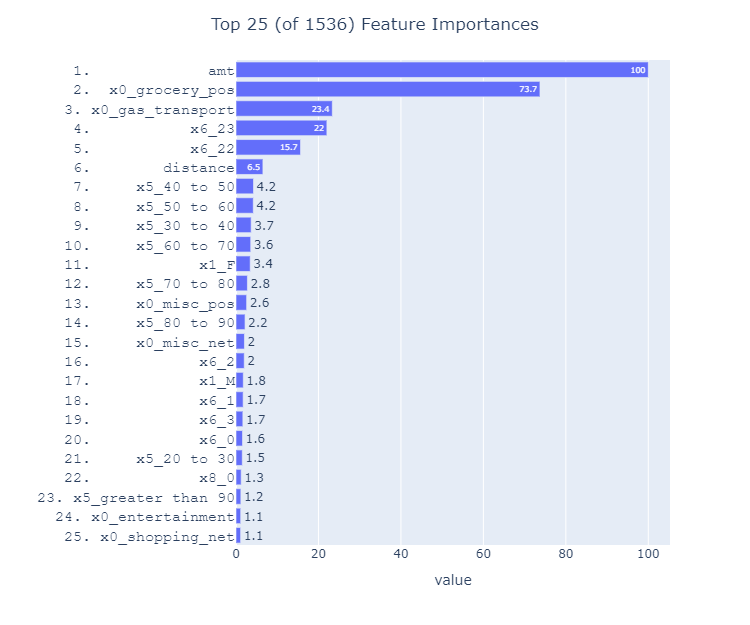

In [1]:
from IPython.display import Image
Image('newplot.png')